In [19]:
import inspect
import time
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from IPython.display import VimeoVideo
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")


In [70]:
def wrangle(filepath):

    # Read CSV file
    df = pd.read_csv(filepath)
    
    # Drop a  all column
    df = df.drop(columns=["unix",'symbol','low','open','high','Volume BTC','Volume USD'])


    # Convert date column to datetime format
    df["date"] = pd.to_datetime(df["date"])

    # Set date column as index
    df.set_index("date", inplace=True)

    # Localize timezone
    #df.index = df.index.tz_localize("UTC")

    # Remove outliers
    #df = df[df["P2"] < 500]

    # Resample to 1day window
    y = df["close"].resample("1D").mean().fillna(method='ffill')

    return y

In [71]:
y=wrangle(r'C:\Users\Nassoh\Desktop\DataSienceMyProject\BTC Price\Data\BTCUSD_day.csv')
y.shape

(3071,)

# Split

In [80]:
Prediction=y.shape[0]-7
cutoff_test =int(Prediction)
y_train =y.iloc[:cutoff_test]
y_test =y.iloc[cutoff_test:]
y_train

date
2014-11-28      376.28
2014-11-29      376.72
2014-11-30      373.34
2014-12-01      378.39
2014-12-02      379.25
                ...   
2023-04-14    30498.00
2023-04-15    30332.00
2023-04-16    30330.00
2023-04-17    29448.00
2023-04-18    30395.00
Freq: D, Name: close, Length: 3064, dtype: float64

In [81]:
y_test

date
2023-04-19    28827.0
2023-04-20    28238.0
2023-04-21    27254.0
2023-04-22    27817.0
2023-04-23    27596.0
2023-04-24    27512.0
2023-04-25    27521.0
Freq: D, Name: close, dtype: float64

# Baseline

In [82]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean BTC Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean BTC Reading: 13529.41
Baseline MAE: 12584.82


# Model

In [83]:
# Create ranges for possible  𝑝 and  𝑞 values
p_params = range(0,25,8)
q_params = range(0,3,1)

In [84]:
print(list(p_params))
print(list(q_params))

[0, 8, 16, 24]
[0, 1, 2]


In [27]:
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model =ARIMA(y_train,order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred =model.predict()
        # Calculate training MAE
        mae =mean_absolute_error(y_train,y_pred)
        # print mae 
        print("MAE : ",mae)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (0, 0, 0) in 0.07 seconds.
MAE :  12611.407547070248
Trained ARIMA (0, 0, 1) in 0.73 seconds.
MAE :  6428.838873256858
Trained ARIMA (0, 0, 2) in 2.4 seconds.
MAE :  5155.815484398115
Trained ARIMA (8, 0, 0) in 0.62 seconds.
MAE :  381.72474436936074
Trained ARIMA (8, 0, 1) in 3.87 seconds.
MAE :  381.61549513108906
Trained ARIMA (8, 0, 2) in 7.33 seconds.
MAE :  380.7094948733574
Trained ARIMA (16, 0, 0) in 3.79 seconds.
MAE :  382.5685327643636
Trained ARIMA (16, 0, 1) in 6.37 seconds.
MAE :  383.3199693469253
Trained ARIMA (16, 0, 2) in 6.99 seconds.
MAE :  383.56219501258215
Trained ARIMA (24, 0, 0) in 10.02 seconds.
MAE :  383.446096109276
Trained ARIMA (24, 0, 1) in 15.14 seconds.
MAE :  382.556212351387
Trained ARIMA (24, 0, 2) in 39.18 seconds.
MAE :  380.80055701746153

{0: [12611.407547070248, 6428.838873256858, 5155.815484398115], 8: [381.72474436936074, 381.61549513108906, 380.7094948733574], 16: [382.5685327643636, 383.3199693469253, 383.56219501258215], 24: 

# Best params
 Trained ARIMA (8, 0, 1) in 10.33 seconds.
 MAE :  108.04601258159315
 p=8 , q=1

In [28]:
mae_df =pd.DataFrame(mae_grid)
mae_df.round(4)

,0,8,16,24
0,12611.4075,381.7247,382.5685,383.4461
1,6428.8389,381.6155,383.3200,382.5562
2,5155.8155,380.7095,383.5622,380.8006


In [29]:
sns.heatmap(mae_df)
plt.xlabel('p values')
plt.ylabel('q values')
plt.title('ARMA Grid Search (MAE)')

Text(0.5, 1.0, 'ARMA Grid Search (MAE)')

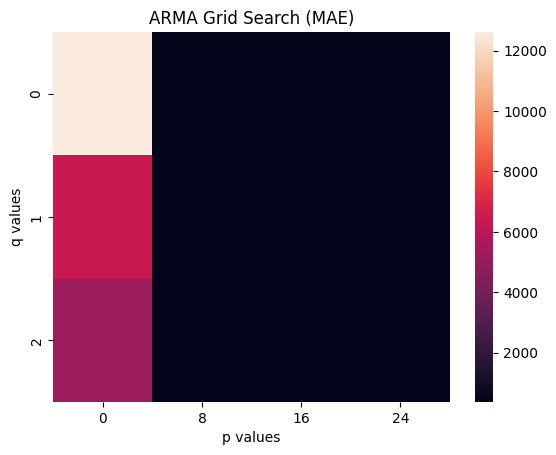

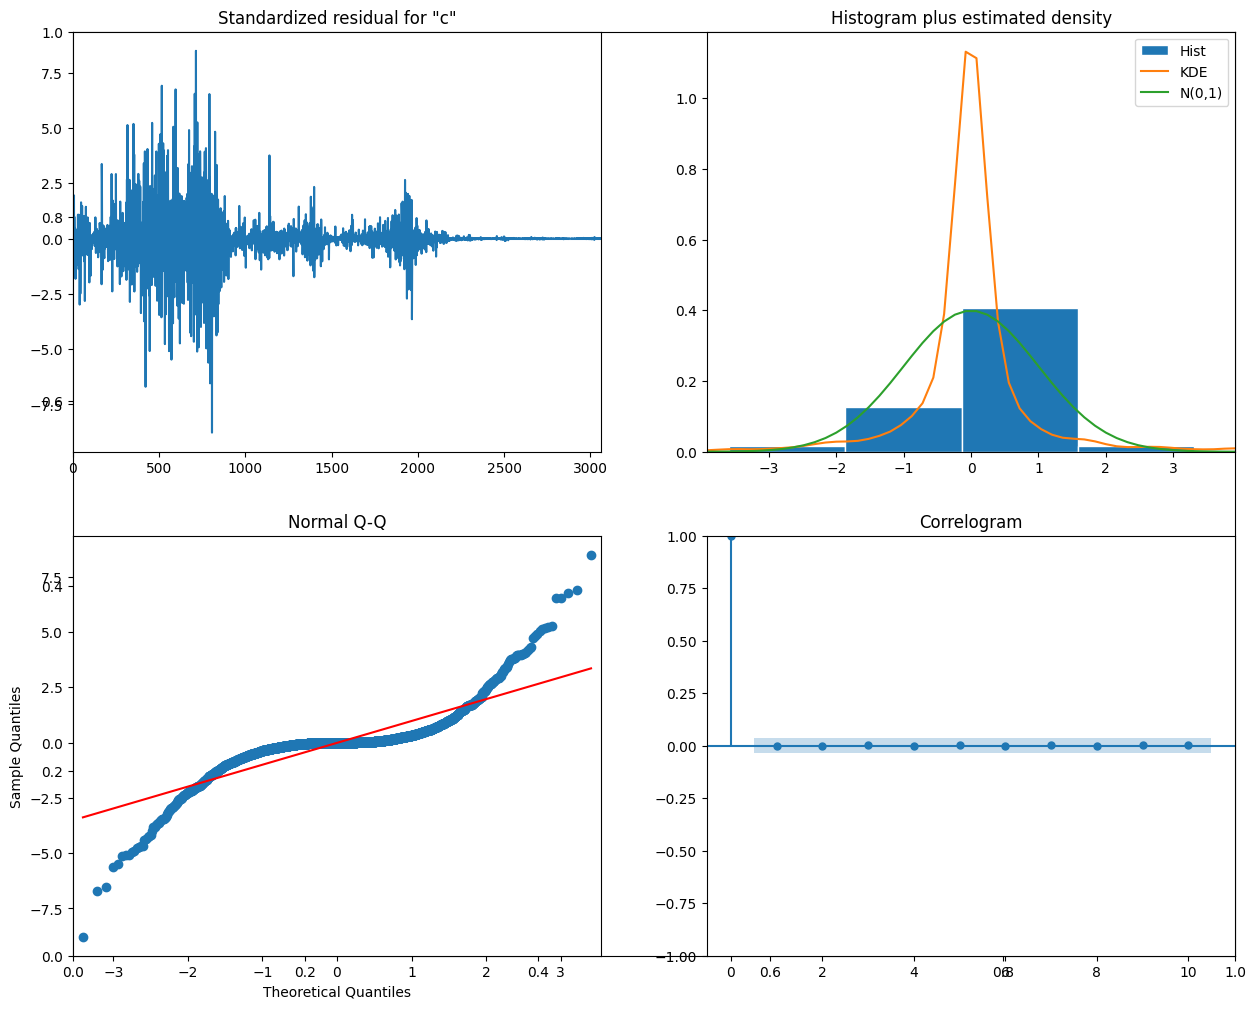

In [30]:
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig=fig)
plt.show()

# Evaluate

In [85]:
model =ARIMA(y_train,order=(8,0,2)).fit()

In [87]:
y_pred_train =model.predict(y_train.index.min(),y_train.index.max())
training_mae =mean_absolute_error(y_train,y_pred_train)

In [88]:
y_pred_test =model.predict(y_test.index.min(),y_test.index.max())
test_mae =mean_absolute_error(y_test,y_pred_test)
print("Baseline MAE:", round(mae_baseline, 2))
print("Training MAE:", training_mae)
print("Test MAE:", test_mae)

Baseline MAE: 12584.82
Training MAE: 378.1613292627449
Test MAE: 2459.6268903149758


In [89]:
df_pred_train = pd.DataFrame(
    {"y_train": y_train, "y_pred_train": y_pred_train},
)
df_pred_train

,y_train,y_pred_train
date,,
2014-11-28,376.28,13529.409427
2014-11-29,376.72,377.200864
2014-11-30,373.34,377.589647
2014-12-01,378.39,374.353808
2014-12-02,379.25,379.103815
...,...,...
2023-04-14,30498.00,30605.228469
2023-04-15,30332.00,30536.896523
2023-04-16,30330.00,30206.833307


In [91]:
fig = px.line(df_pred_train, labels={"value": "BTC"},title='Train Data')
fig.show()

In [92]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test},
)
df_pred_test

,y_test,y_pred
2023-04-19,28827.0,30342.158176
2023-04-20,28238.0,30223.309021
2023-04-21,27254.0,30231.265473
2023-04-22,27817.0,30353.982498
2023-04-23,27596.0,30299.310186
2023-04-24,27512.0,30243.237287
2023-04-25,27521.0,30289.125591


In [93]:
fig = px.line(df_pred_test, labels={"value": "BTC"},title='Test Data')
fig.show()

In [94]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model =ARIMA(history,order=(8,0,1)).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

In [95]:
test_mae =mean_absolute_error(y_test,y_pred_wfv)
print("Baseline MAE:", round(mae_baseline, 2))
print("Training MAE:", training_mae)
print("Test MAE:", test_mae)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Baseline MAE: 12584.82
Training MAE: 378.1613292627449
Test MAE: 563.5643979623684
Test MAE (walk forward validation): 563.56


In [96]:
df_predictions =pd.DataFrame({'y_test':y_test,'y_pred_wfv':y_pred_wfv})
fig =px.line(df_predictions,labels={'value':'BTC'})
fig.show()

In [97]:
model.params

const      13557.444510
ar.L1          1.131781
ar.L2         -0.123933
ar.L3          0.017791
ar.L4          0.002090
ar.L5         -0.015983
ar.L6          0.005999
ar.L7         -0.069792
ar.L8          0.050933
ma.L1         -0.167251
sigma2    647542.038389
dtype: float64